### Dependencies

In [2]:
import sys, os
from csv import DictWriter

import numpy as np
import pandas as pd
import torch as T
from scipy.integrate import solve_ivp

from dataclasses import dataclass

import torch_optimizer as optim_all

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
plt.style.use("seaborn-v0_8-whitegrid")

### Physical Model

#### Forcing

In [1]:
def apply_forcing(times, params):
    """
    A function that returns the forcing term for the given time instance

    Parameters
    ----------
    times : numpy.ndarray
        an 1D array containing the discrete time values 
    params : parameters dataclass
        the parameters of the run
    Returns
    -------
    numpy.ndarray
        an 1D array that contains the forcing term for the input discrete time instances    
    """

    if params.force_flag == 'Jonswap':
        return np.expand_dims((np.expand_dims(params.aps, 1) * np.cos((np.expand_dims(params.omegaps, 1) * np.expand_dims(times, 0) + np.expand_dims(params.eps, 1)))).sum(axis=0), axis=1)
    elif params.force_flag == 'mono':
        return params.F0 * np.cos(params.forcing_freq * times)
    else:
        print("Wrong excitation flag was given\nValid options are:\n'Jonswap'\n'mono'")

#### Known physics - Discrepancy bias

In [10]:
def apply_known_physics(x, times, params):
    """
    A function that returns the known part (terms) of the governing equation

    Parameters
    ----------
    x : numpy.ndarray or torch.Tensor
        a 2D array/tensor containing the displacement in the first column and the velocity in the second one
    times : numpy.ndarray or torch.Tensor
        an 1D array/tensor containing the discrete time values 
    params : parameters dataclass
        the parameters of the run
    Returns
    -------
    numpy.ndarray or torch.Tensor
        an 1D array/tensor that contains known part of the governing equation   
    """
    return - 2 * params.zeta * params.omega * x[:, 1] - params.omega ** 2 * x[:, 0]

#### True model

In [3]:
def build_true_model(x, t, params):
    """
    A function that gets the displacement, velocity and time as an input, and returns the true vector field output (velocity and acceleration)

    Parameters
    ----------
    x : numpy.ndarray 
        a 2D array containing the displacement in the first column and the velocity in the second one
    t : numpy.ndarray
        an 1D array containing the discrete time values 
    params : parameters dataclass
        the parameters of the run
    Returns
    -------
    numpy.ndarray
        a 2D array with the two vector field values, velocity as first column and acceleration as second, for the given input x and t
    """

    if params.friction_model == "C":
        friction_force = params.friction_force_ratio
    elif params.friction_model == "DR":
        friction_force = params.friction_force_ratio \
                       + params.DR["a"] * np.log((np.abs(x[1]) + params.DR["eps"]) / params.DR["V_star"]) \
                       + params.DR["b"] * np.log(params.DR["c"] + params.DR["V_star"] / (np.abs(x[1]) + params.DR["eps"]))
    elif params.friction_model is None:
        friction_force = 0
    
    forcing = apply_forcing(t, params)
    # Check if there is sticking - Zero velocity and friction force bigger than the opposing forces
    if (np.abs(x[1]) < 1e-5) and (np.abs(forcing - params.stiffness * x[0]) <= np.abs(friction_force) * params.F0):
        return np.array([0., 0.])
    else:
        return np.array([x[1], 
                         - 2 * params.zeta * params.omega * x[1] 
                         - params.omega ** 2 * x[0] 
                         - friction_force * params.F0 / params.mass * np.sign(x[1]) 
                         + forcing / params.mass], dtype=object)
    

#### Generate synthetic data

In [4]:
def generate_data(params):
    """
    A function that solves the system's equation and generates the ground truth data based on the defined run parameters

    Parameters
    ----------
    params : parameters dataclass
        the parameters of the run
    Returns
    -------
    numpy.ndarray
        an 1D array with the discrete time instances
    numpy.ndarray
        a 2D array with the ground truth data, displacements as first column and velocities as second
    """
    #Generate (noisy) measurements - Training Data
    ts = np.arange(0, params.timefinal, params.timestep)

    # Solve the equation
    sol = solve_ivp(
        lambda t, x: build_true_model(x, t, params), 
        t_span=[ts[0], ts[-1]], y0=params.x0, t_eval=ts
        )

    return ts, np.transpose(sol.y)

### Coefficients dictionary

In [5]:
class CoeffsDictionary(T.nn.Module):
    """
    A class for initializing, storing, and updating the ksi coefficients
    These coefficients are the linear weights of a neural network
    The class inherits from the torch.nn.Module
    """
    def __init__(self, n_combinations):

        super(CoeffsDictionary, self).__init__()
        self.linear = T.nn.Linear(n_combinations, 1, bias=False)
        # Setting the weights to zeros
        self.linear.weight = T.nn.Parameter(0 * self.linear.weight.clone().detach())
    
    def forward(self, x):
        
        return self.linear(x)

### Features function

In [6]:
def apply_features(x, t, params, torch_flag=True):
    """
    Applies the feature candidates to the given data

    Parameters
    ----------
    x : numpy.ndarray or torch.Tensor
        a 2D array/tensor containing the displacement in the first column and the velocity in the second one
    t : numpy.ndarray or torch.Tensor
        an 1D array/tensor containing the discrete time values 
    params : parameters dataclass
        the parameters of the run
    torch_flag : bool
        if True, the type of x, t and return object is torch.Tensor, otherwise numpy.ndarray
    Returns
    -------
    numpy.ndarray or torch.Tensor
        a 2D array/tensor with the two vector field values, velocity as first column and acceleration as second, 
        applying the assumed features on the given input x and t
    
    """
    if torch_flag:
        return T.column_stack(
            (
                *[T.cos(ph * t) for ph in params.cos_phases], # cosine features
                *[T.sin(ph * t) for ph in params.sin_phases], # sine features
                *[T.sign(x[:, 0]),] * params.x_sgn_flag, # x signum feature
                *[T.sign(x[:, 1]),] * params.y_sgn_flag, # y signum feature
                *[T.log((T.abs(x[:, 1]) + params.DR["eps"]) / params.DR["V_star"]),] * params.log_1, # natural log of abs vel
                *[T.log(params.DR["c"] + params.DR["V_star"] / (T.abs(x[:, 1]) + params.DR["eps"])),] * params.log_2, # natural log of abs displ
                *[T.ones(size=(x.shape[0],))] * (params.poly_order >= 0), 
                *[x[:, 0], x[:, 1]] * (params.poly_order >= 1),
                *[x[:, 0] ** 2, x[:, 0] * x[:, 1], x[:, 1] ** 2] * (params.poly_order >= 2),
                *[x[:, 0] ** 3, x[:, 0] ** 2 * x[:, 1], x[:, 0] * x[:, 1] ** 2, x[:, 1] ** 3,] * (params.poly_order >= 3),
                *[x[:, 0] ** 4, x[:, 0] ** 3 * x[:, 1], x[:, 0] ** 2 * x[:, 1] ** 2, x[:, 0] * x[:, 1] ** 3, x[:, 1] ** 4] * (params.poly_order >= 4), # polynomial features
            )
        )
    else:
        return np.column_stack(
        (
            *[np.cos(ph * t) for ph in params.cos_phases], # cosine features                
            *[np.sin(ph * t) for ph in params.sin_phases], # sine features                
            *[np.sign(x[:, 0]),] * params.x_sgn_flag, # x signum feature 
            *[np.sign(x[:, 1]),] * params.y_sgn_flag, # y signum feature
            *[np.log((np.abs(x[:, 1]) + params.DR["eps"]) / params.DR["V_star"]),] * params.log_1, # natural log of abs vel
            *[np.log(params.DR["c"] + params.DR["V_star"] / (np.abs(x[:, 1]) + params.DR["eps"])),] * params.log_2, # natural log of abs displ
            *[np.ones(shape=(x.shape[0],))] * (params.poly_order >= 0), 
            *[x[:, 0], x[:, 1]] * (params.poly_order >= 1),
            *[x[:, 0] ** 2, x[:, 0] * x[:, 1], x[:, 1] ** 2] * (params.poly_order >= 2),
            *[x[:, 0] ** 3, x[:, 0] ** 2 * x[:, 1], x[:, 0] * x[:, 1] ** 2, x[:, 1] ** 3,] * (params.poly_order >= 3),
            *[x[:, 0] ** 4, x[:, 0] ** 3 * x[:, 1], x[:, 0] ** 2 * x[:, 1] ** 2, x[:, 0] * x[:, 1] ** 3, x[:, 1] ** 4] * (params.poly_order >= 4), # polynomial features
        )
    )


#### Store the selected features as strings in a list

In [7]:
def get_feature_names(params):
    """"
    A function that stores the assumed features as strings

    Parameters
    ----------
    params : parameters dataclass
        the parameters of the run

    Returns
    -------
    list
        the list containing the assumed features as strings
    """
    return [*[f"cos({ph:.1f} t)" for ph in params.cos_phases], 
            *[f"sin({ph:.1f} t)" for ph in params.sin_phases], 
            *["sgn(x)",] * params.x_sgn_flag,
            *["sgn(y)",] * params.y_sgn_flag,
            *[f"ln((|y| + {params.DR['eps']:.1e}) / {params.DR['V_star']:.3f})", ] * params.log_1,
            *[f"ln({params.DR['c']:.3f} + {params.DR['V_star']:.3f} / (|y| + {params.DR['eps']:.1e}))",] * params.log_2,
            *["1",] * (params.poly_order >= 0),
            *["x", "y"] * (params.poly_order >= 1),
            *["x^2", "xy", "y^2"] * (params.poly_order >= 2),
            *["x^3", "x^2y", "xy^2", "y^3"] * (params.poly_order >= 3),
            *["x^4", "x^3y", "x^2y^2", "xy^3", "y^4"] * (params.poly_order >= 4),]

#### Print the learnt equation

In [8]:
def print_learnt_equation(learnt_coeffs, params):
    """"
    A function that combines the learnt coefficients and the assumed features 
    to form the governing equation

    Parameters
    ----------
    learnt_coeffs : numpy.ndarray
        an array containing the learnt coefficients
    params : parameters dataclass
        the parameters of the run

    Returns
    -------
    str
        the governing equation
    """
    feature_names = get_feature_names(params)
    
    string_list = [f'{"+" if coeff > 0  else ""}{coeff:.3f} {feat}' for coeff, feat in zip(np.squeeze(learnt_coeffs, axis=1), feature_names) if np.abs(coeff) > 1e-5]

    equation = " ".join(string_list)

    if equation[0] == "+":
        equation = equation[1:]
    
    return equation 

### 4th order Runge-Kutta constraint function

In [12]:
def apply_rk4_SparseId_known_forcing(x, coeffs, times, f_1, f_m, f_2, timesteps, params):
    """
    A function that applies the fourth order Runge-Kutta scheme to the given data in order to derive the ones in the following timestep
    During this process the approximate derivatives are used
   
    Parameters
    ----------
    x : torch.Tensor
        a 2D tensor containing the displacement in the first column and the velocity in the second one
    coeffs : CoeffsDictionary object
        the neural network with the sought coefficients as its weights
    times : torch.Tensor
        an 1D tensor containing the discrete time values
    f_1 : torch.Tensor
        an 1D tensor containing the forcing at the current timestep
    f_m : torch.Tensor
        an 1D tensor containing the average of the current and next timestep forcing
    f_2 : torch.Tensor
        an 1D tensor containing the forcing at the next timestep
    timesteps : torch.Tensor
        an 1D tensor containing the discrete time intervals
    params : parameters dataclass
        the parameters of the run

    Returns
    -------
    torch.Tensor
        Predictions of both displacement and velocity for the next timesteps
    
    """
    
    d1 = apply_features(x, times, params)
    k1 = T.column_stack((x[:, 1].unsqueeze(1), 
                         apply_known_physics(x, times, params).unsqueeze(1)
                         + f_1 /params.mass
                         - coeffs(d1) * params.F0 / params.mass * T.sign(x[:, 1]).unsqueeze(1)))

    k1 = T.where((T.abs(x[:, 1]).unsqueeze(1) <= params.stick_tol), 0., k1)
    
    xtemp = x + 0.5 * timesteps * k1
    d2 = apply_features(xtemp, times + 0.5 * timesteps, params)
    k2 = T.column_stack((xtemp[:, 1].unsqueeze(1), 
                         apply_known_physics(xtemp, times + 0.5 * timesteps, params).unsqueeze(1)
                          + f_m /params.mass 
                          - coeffs(d2) * params.F0 / params.mass * T.sign(xtemp[:, 1]).unsqueeze(1)))
                    

    k2 = T.where((T.abs(xtemp[:, 1]).unsqueeze(1) <= params.stick_tol), 0., k2)

    xtemp = x + 0.5 * timesteps * k2
    d3 = apply_features(xtemp, times + 0.5 * timesteps, params)
    k3 = T.column_stack((xtemp[:, 1].unsqueeze(1), 
                         apply_known_physics(xtemp, times + 0.5 * timesteps, params).unsqueeze(1)
                          + f_m /params.mass 
                          - coeffs(d3) * params.F0 / params.mass * T.sign(xtemp[:, 1]).unsqueeze(1)))
                    
    
    k3 = T.where((T.abs(xtemp[:, 1]).unsqueeze(1) <= params.stick_tol), 0., k3)

    xtemp = x + timesteps * k3
    d4 = apply_features(xtemp, times + timesteps, params)
    k4 = T.column_stack((xtemp[:, 1].unsqueeze(1), 
                         apply_known_physics(xtemp, times + timesteps, params).unsqueeze(1)
                          + f_2 /params.mass
                          - coeffs(d4) * params.F0 / params.mass * T.sign(xtemp[:, 1]).unsqueeze(1)))
                    
    
    k4 = T.where((T.abs(xtemp[:, 1]).unsqueeze(1) <= params.stick_tol), 0., k4)

    return x + (1 / 6) * (k1 + 2 * k2 + 2 * k3 + k4) * timesteps

### Torch standard scaler

In [13]:
def scale_torch(unscaled_tensor, params):
    """
    A function that applies a standard scaling to a torch tensor

    Parameters
    ----------
    unscaled_tensor ; torch.tensor
        a 2D tensor we wish to scale
    params : parameters dataclass
        the parameters of the run

    Returns
    -------
    torch.tensor
        the scaled tensor
    """
    return (unscaled_tensor - params.mus) / params.stds

### Learning function

In [14]:
def learn_sparse_model(coeffs, train_set, times, f, f_m, params, lr_reduction=10):
    """"
    A function that calculates which ksi coefficients lead to optimal prediction
    The updating of the coefficients is performed in a deep learning fashion

    Parameters
    ----------
    coeffs : CoeffsDictionary object
        the neural network with the sought coefficients as its weights
    train_set : torch.Tensor
        a 2D tensor containing the displacement in the first column and the velocity in the second one
    times : torch.Tensor
        an 1D tensor containing the discrete time values
    f : torch.Tensor
        an 1D tensor containing the forcing at the discrete time values
    f_m : torch.Tensor
        an 1D tensor containing the average of the forcing i.e. forcing at in-between time instances
    params : parameters dataclass
        the parameters of the run
    lr_reduction : int
        the value that the learning rate is divided by in each training batch

    Returns
    -------
    coeffs : CoeffsDictionary object
        the neural network with the updated/learnt coefficients as its weights
    loss_track : numpy.ndarray
        a 2D array containing the loss for each training batch (row), for each epoch (column)
    """
    # Define optimizer
    opt_func = optim_all.RAdam(
        coeffs.parameters(), lr=params.lr, weight_decay=params.weightdecay
    )
    # Define loss function
    criteria = T.nn.MSELoss()
    # pre-allocate memory for loss_fuction
    loss_track = np.zeros((params.num_iter, params.num_epochs))

    # Training 
    for p in range(params.num_iter):
        for g in range(params.num_epochs):
            coeffs.train()

            opt_func.zero_grad()

            loss_new = T.autograd.Variable(T.tensor([0.0], requires_grad=True))
            weights = 2 ** (-0.5 * T.linspace(0, 0, 1))

            timesteps_i = T.tensor(np.diff(times, axis=0)).float()

            # One forward step predictions
            y_pred = apply_rk4_SparseId_known_forcing(train_set[:-1], coeffs, times[:-1], f[:-1], f_m, f[1:], timesteps=timesteps_i, params=params)

            # One backward step predictions
            y_pred_back = apply_rk4_SparseId_known_forcing(train_set[1:], coeffs, times[1:], f[1:], f_m, f[:-1], timesteps=-timesteps_i, params=params)
           
            if params.scaling:
                y_pred_scaled = scale_torch(y_pred, params)
                y_pred_back_scaled = scale_torch(y_pred_back, params)
                train_set_scaled = scale_torch(train_set, params)
                
                loss_new += criteria(y_pred_scaled, train_set_scaled[1:]) + weights[0] * criteria(
                    y_pred_back_scaled, train_set_scaled[:-1]
                )
            else:
                loss_new += criteria(y_pred, train_set[1:]) + weights[0] * criteria(
                    y_pred_back, train_set[:-1]
                )

            loss_track[p, g] += loss_new.item()
            loss_new.backward()
            opt_func.step()

            sys.stdout.write("\r [Iter %d/%d] [Epoch %d/%d] [Training loss: %.2e] [Learning rate: %.2e]" % (p + 1, params.num_iter, g + 1, params.num_epochs, loss_track[p, g], opt_func.param_groups[0]["lr"],))

        # Removing the coefficients smaller than tol and set gradients w.r.t. them to zero
        # so that they will not be updated in the iterations
        Ws = coeffs.linear.weight.detach().clone()
        Mask_Ws = (Ws.abs() > params.tol_coeffs).type(T.float)
        coeffs.linear.weight = T.nn.Parameter(Ws * Mask_Ws)

        coeffs.linear.weight.register_hook(lambda grad: grad.mul_(Mask_Ws))
        new_lr = opt_func.param_groups[0]["lr"] / lr_reduction
        opt_func = optim_all.RAdam(coeffs.parameters(), lr=new_lr, weight_decay=params.weightdecay)

    return coeffs, loss_track

In [15]:
def setup_directories(child_dir):
    """"
    A function that checks if the directory, where the run's data will be saved, exists. 
    In case it does, stored date will be overwritten, otherwise, this new directory will be created

    Parameters
    ----------
    child_dir : str
        the path of the directory to be created
    """
    if os.path.isdir(child_dir):
        print("""
        ------------------------------------------------------------------------------
        WARNING, the directory already exists, you are about to overwrite some data!!!
        ------------------------------------------------------------------------------
        """, sep=os.linesep)
    else:
        os.makedirs(child_dir)

In [16]:
def store_results(params, loss, coeffs, parent_dir, child_dir):
    """"
    A function that appends the hyperparameters and the derived solution to the .csv with all the stored results.
    It also saves the losses and the derived ksi coefficients

    Parameters
    ----------
    params : parameters dataclass
        the parameters of the run
    loss : numpy.ndarray
        the losses stored during every epoch of every training batch
    coeffs : numpy.ndarray
        the ksi coefficients derived after applying RK4SINDy
    parent_dir : str
        the path of the directory that contains info for all runs
    child_dir : str
        the path of the directory that will contain the results of the current run
    """  
    param_dict = params.__dict__
    csv_file = 'hyperparameters.csv'

    with open(os.path.join(parent_dir, csv_file), "a", newline='') as file_object:
        dict_writer_object = DictWriter(file_object, fieldnames=list(param_dict.keys()))

        if params.id == "1":
            dict_writer_object.writeheader()
        
        dict_writer_object.writerow(param_dict)

    np.save(os.path.join(child_dir, "losses.npy"), loss)
    np.save(os.path.join(child_dir, "coeffs.npy"), coeffs)

In [17]:
def plot_results(times, exact_sol, measurements, learnt_sol, child_dir, type_flag='d', save_flag=True, figsize=(16, 8)):
    """"
    A function that plots and saves the comparison between the learnt solution, the exact solution and the used measurements

    Parameters
    ----------
    times : numpy.ndarray
        an 1D matrix containing the discrete time values
    exact_sol : numpy.ndarray
        a 2D array containing displacement and velocity values for each time step according to the exact equation 
    measurements : numpy.ndarray
        a 2D array containing noisy displacement and velocity measurement for each time step 
    learnt_sol : str
        a 2D array containing displacement and velocity values for each time step according to the learnt equation 
    child_dir : str
        the path of the directory that will contain the results of the current run
    type_flag : bool
        if set to 'd', the displacement plot will be generated/saved, if set to 'v', the velocity one
    """ 
    plt.figure(figsize=figsize)

    plt.plot(times[::20], measurements[::20], "ro", markersize=5, label="Measurements")
    plt.plot(times, learnt_sol, "k--", linewidth=2, label="RK4-SINDy")
    plt.plot(times, exact_sol, alpha=0.3, linewidth=4, label="Ground truth")

    plt.legend(fontsize=22)#, bbox_to_anchor=(1., 0.6))#, loc='upper right')
    
    plt.xlabel(r"$t \, \, \mathrm{[s]}$", fontsize=24)
    if type_flag == 'd':
        plt.ylabel(r"$x(t) \, \, \mathrm{[m]}$", fontsize=24)
    elif type_flag == 'v':
        plt.ylabel(r"$\dot{x}(t) \, \, \mathrm{[m/s]}$", fontsize=24)
    else:
        print("A wrong type_flag was given\nIt should be either 'd' for displacements, or 'v' for velocities")
        
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    if save_flag:
        plt.savefig(os.path.join(child_dir, f"{type_flag}.png"), bbox_inches='tight')

    plt.show()

In [18]:
def plot_error(times, exact_sol, learnt_sol, nrmse, child_dir, type_flag='d', save_flag=True, figsize=(16,12)):
    """"
    A function that plots and saves the squared error between the learnt solution and the exact one

    Parameters
    ----------
    times : numpy.ndarray
        an 1D matrix containing the discrete time values
    exact_sol : numpy.ndarray
        a 2D array containing displacement and velocity values for each time step according to the exact equation 
    learnt_sol : str
        a 2D array containing displacement and velocity values for each time step according to the learnt equation 
    rmse : numpy.ndarray
        a 2D array containing the root mean squared error between the exact solution and the learnt one, for both displacements and velocities
    child_dir : str
        the path of the directory that will contain the results of the current run
    type_flag : bool
        if set to 'd', the displacement plot will be generated/saved, if set to 'v', the velocity one
    """ 
    if type_flag == 'd':
        ind = 0
    elif type_flag == 'v':
        ind = 1
    else:
        print("A wrong type_flag was given\nIt should be either 'd' for displacements, or 'v' for velocities")
    
    squaredError = np.abs(exact_sol - learnt_sol)

    _, ax = plt.subplots(figsize=figsize)

    ax.plot(times, squaredError[:, ind], label="Squared Error")

    textstr = f"NRMSE : {nrmse[ind]:.4f}"

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=24,
            verticalalignment='top', bbox=props)

    ax.set_xlabel(r"$t \, \, \mathrm{[s]}$", fontsize=24)
    if ind == 0:
        ax.set_ylabel(r"$\mid x_{\mathrm{true}} - x_{\mathrm{learned}} \mid \, \, \mathrm{[m]}$", fontsize=24)
    elif ind == 1:
        ax.set_ylabel(r"$\mid \dot{x}_{\mathrm{true}} - \dot{x}_{\mathrm{learned}}\mid \, \, \mathrm{[m/s]}$", fontsize=24)

    ax.tick_params(axis='both', which='major', labelsize=20)

    if save_flag:
        plt.savefig(os.path.join(child_dir, "err.png"), bbox_inches='tight')

    plt.show()

#### Random seed

In [27]:
randSeed = 42

T.manual_seed(randSeed)
np.random.seed(seed=randSeed)

### Parameters dataclass

In [28]:
@dataclass
class parameters:
    # Learning hyperparameters
    num_epochs = 1000
    num_iter = 3
    lr = 1e-1
    weightdecay = 0.0
    tol_coeffs: float = 1e-1
    scaling: bool = True

    timestep: float = 1e-2 # 5e-4
    
    # Assumed features
    poly_order: int = 1
    # cos_phases: np.ndarray = np.arange(0.1, 0.51, 0.1)
    # sin_phases: np.ndarray = np.arange(0.1, 0.51, 0.1)
    cos_phases: np.ndarray = ()
    sin_phases: np.ndarray = ()
    x_sgn_flag: bool = False
    y_sgn_flag: bool = False
    log_1: bool = False
    log_2: bool = False
    
Params = parameters()

#### Physical parameters

In [29]:
Params.timefinal = 50

Params.mass: float = 1.0
Params.stiffness: float = 1. # 64.
Params.damping: float = 0.1 # 5.
Params.omega = np.sqrt(Params.stiffness / Params.mass) 
Params.zeta: float = Params.damping / (2 * np.sqrt(Params.stiffness * Params.mass))
Params.forcing_freq: float = 0.175 # 0.175, 0.3 or 1.2
Params.F0: float = 1.0
Params.force_flag: bool = 'mono' # 'Jonswap', or 'mono'

Params.friction_model_ind: int = 1 # 0: No friction, 1: Coulomb, 2: Dieterich-Ruina

Params.friction_model = [None, "C", "DR"][Params.friction_model_ind]
Params.friction_force_ratio: float = 0.5
Params.DR: dict = {'a': 0.07, 'b': 0.09, 'c': 0.022, 'V_star': 0.003, 'eps': 1e-6}

Params.x0: tuple = (0.1, 0.1)

Params.true_omega: float  = 1.0
Params.true_zeta: float  = 0.05

Params.noisy_measure_flag: bool = True
Params.noise_level: float = 1e-1
Params.noisy_input_flag: bool = False
Params.omega_noise: float = 5e-2
Params.zeta_noise: float = 2e-1

Params.stick_tol: float = 1e-3

### Jonswap spectrum excitation

In [30]:
if Params.force_flag == 'Jonswap':
    Hs = 10
    Tp = 0.5
    fp = 1 / Tp
    omegap = 2 * np.pi / Tp
    omegas = np.arange(0.1, 50.01, 0.1)

    sigmap = np.where((omegas < omegap), 0.07, 0.09)

    gamma = 3.3
    fs = omegas / (2 *np.pi)
    beta = np.exp(-0.5 * ((fs / fp - 1) / sigmap) ** 2)
    Sigmaf = 0.3125 * Hs ** 2 * Tp * (fs / fp) ** (-5) * np.exp(-1.25 * (fs / fp) ** (-4)) * (1 - 0.287 * np.log(gamma)) * gamma ** beta

    SigmaOmega = 320 * (Hs / Tp ** 2) ** 2 * (1 / omegap ** 5) * np.exp(-1.25 * (omegap / omegas) ** 4) * gamma * beta
    
    inds = np.arange(omegas.shape[0])
    noOfHarmonics = omegas.shape[0]
    deltaf = fs[1] - fs[0]
    aps = np.sqrt(2 * Sigmaf[inds] * deltaf)
    eps = 2 * np.pi * np.random.rand(noOfHarmonics)
    
    ts = np.arange(0, Params.timefinal, Params.timestep)

    eta = (np.expand_dims(aps, 1) * np.cos((2 * np.pi * np.expand_dims(fs[inds], 1) * np.expand_dims(ts, 0) + np.expand_dims(eps, 1)))).sum(axis=0)

    Params.F0 = np.abs(eta).max()
    Params.aps = aps
    Params.eps = eps
    Params.omegaps = omegas[inds]

    Params.stick_tol = 1e-3
    
    _, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6))
    ax1.plot(fs, Sigmaf)

    ax1.set_ylabel(r"Spectral Density [m$^2$/Hz]", fontsize=24)
    ax1.set_xlabel(r"Frequency, $f$ [Hz]", fontsize=24)
    ax2.plot(ts, eta)
    ax2.set_xlabel(r"$t$ [s]", fontsize=24)
    ax2.set_ylabel(r"Displacement [m]", fontsize=24)

    ax1.set_xticks(np.arange(0, 8.1, 1), np.arange(0, 8.1, 1), fontsize=20)
    ax1.set_yticks(np.arange(0, 10.1, 2),np.arange(0, 10.1, 2), fontsize=20)
    ax2.set_xticks(np.arange(0, 5.1, 1), np.arange(0, 5.1, 1), fontsize=20)
    ax2.set_yticks(np.arange(-4, 4.1, 2),np.arange(-4, 4.1, 2), fontsize=20)

    ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) 
    ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) 
    ax1.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
    ax2.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
    
    plt.show()

In [31]:
ts, x_denoised = generate_data(Params)

forcing = apply_forcing(ts, Params)
forcing_m = apply_forcing(0.5 * (ts[:-1] + ts[1:]), Params)

if len(forcing.shape) == 1:
    forcing = np.expand_dims(forcing, axis=1)
    forcing_m = np.expand_dims(forcing_m, axis=1)
#Generate noisy measurements
if Params.noisy_measure_flag:
    x = np.random.normal(loc=x_denoised, scale=Params.noise_level * np.abs(x_denoised), size=x_denoised.shape)
else:
    x = x_denoised

# Contaminate omega and zeta with noise
if Params.noisy_input_flag:
    Params.omega = np.clip(np.random.normal(loc=Params.true_omega, scale=Params.omega_noise * Params.true_omega), a_max=None, a_min=0.1)
    Params.zeta = np.clip(np.random.normal(loc=Params.true_zeta, scale=Params.zeta_noise * Params.true_zeta), a_max=0.99, a_min=0.01)
else:
    Params.omega = Params.true_omega
    Params.zeta = Params.true_zeta

### Journal paper plotting style

In [34]:
cm = 1/2.54

fsize = 11
tsize = 18

tdir = 'in'

major = 5.0
minor = 3.0

style = 'default'

plt.style.use(style)
plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.dpi"] = 300
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor

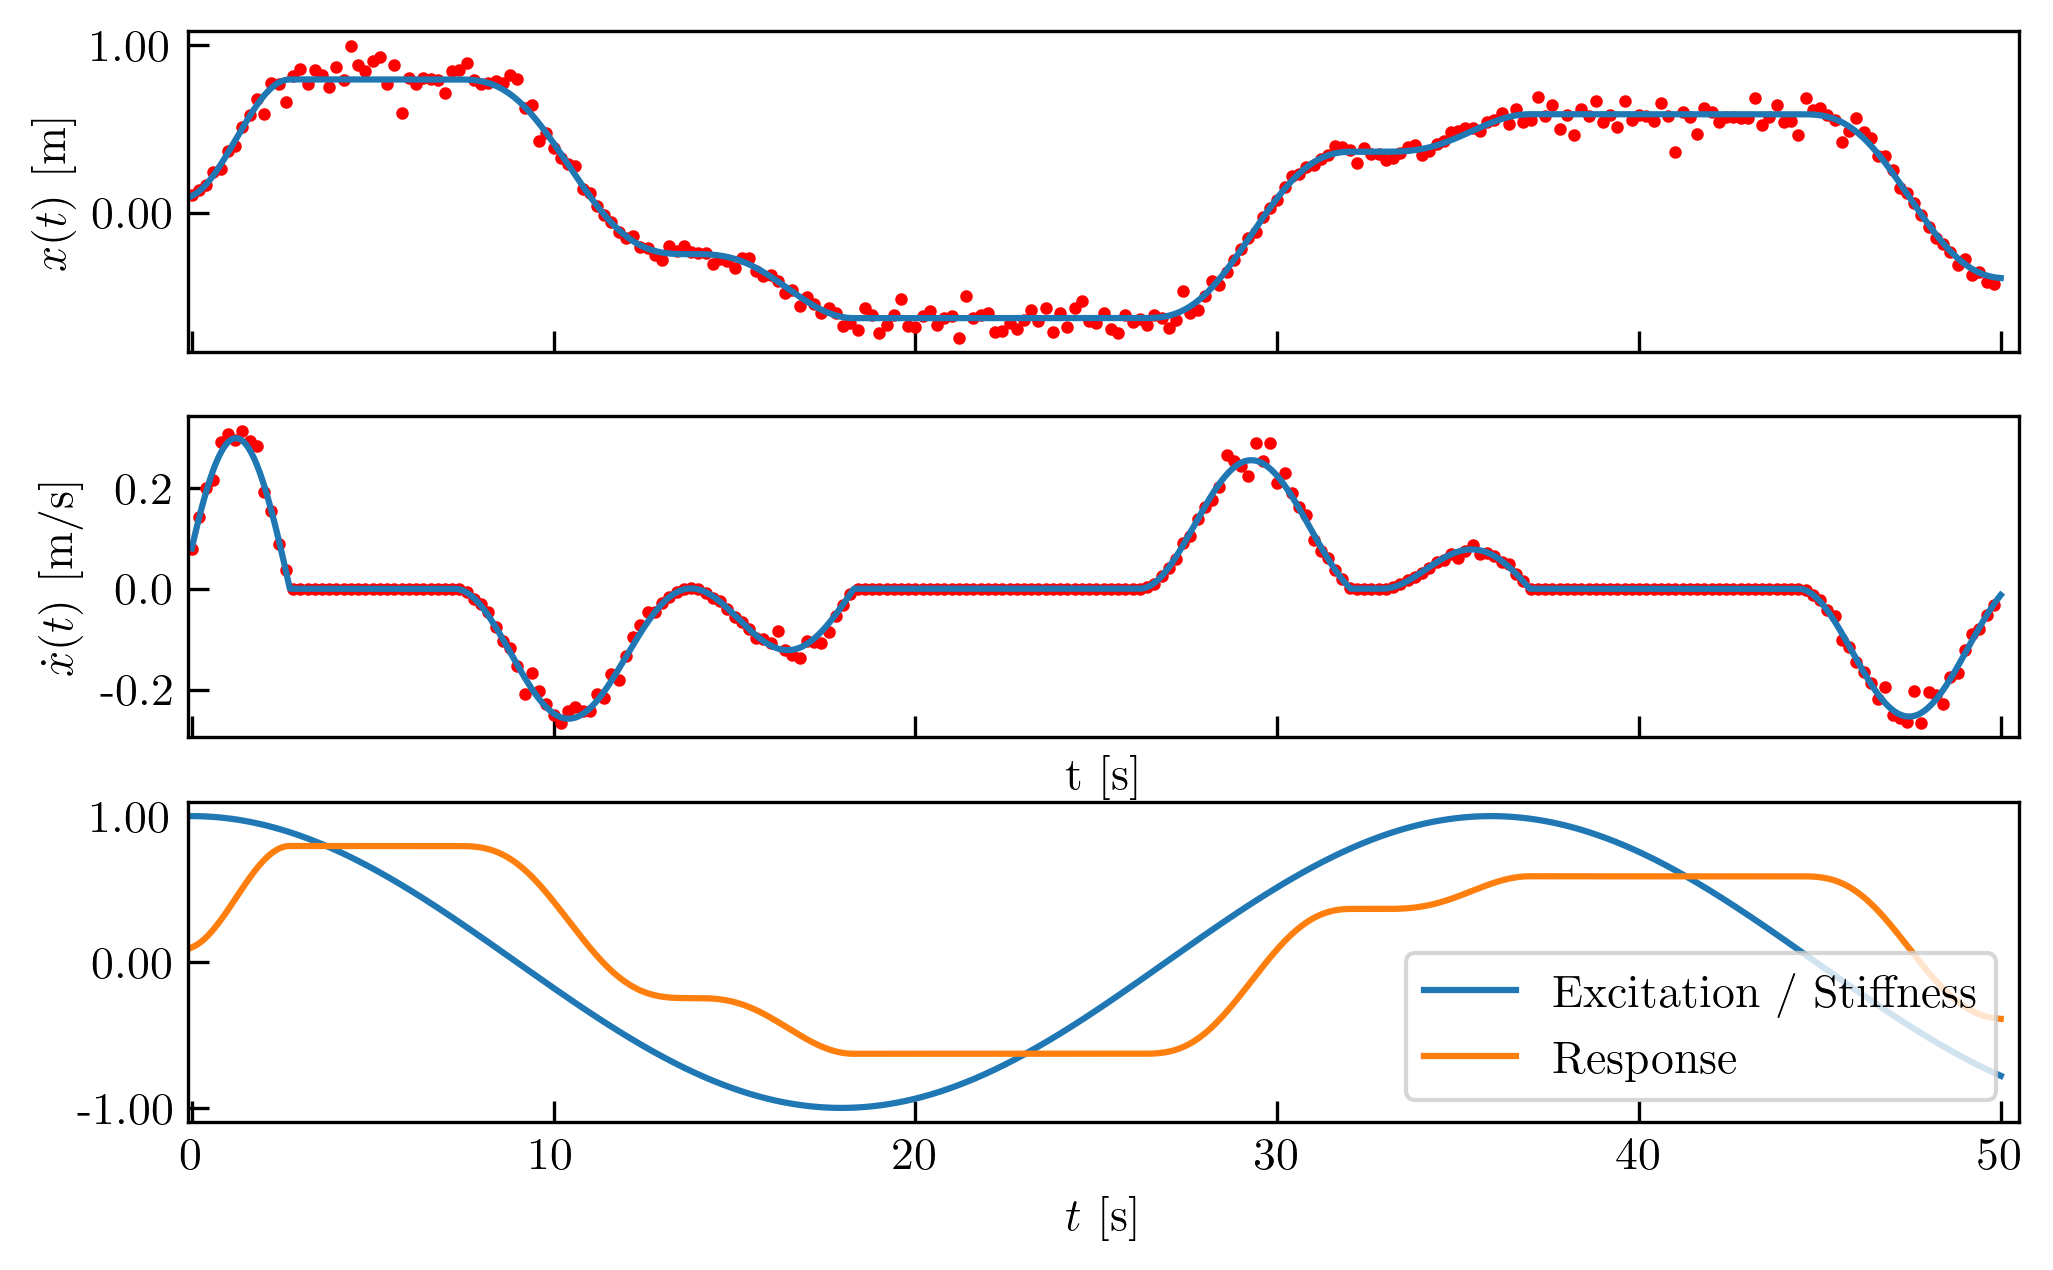

In [36]:
_, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(20*cm,12*cm), sharex=True)
ax1.plot(ts[::20], x[::20, 0],"ro", markersize=2, label='measurements')
ax2.plot(ts[::20], x[::20, 1],"ro", markersize=2, label='measurements')
ax1.plot(ts, x_denoised[:, 0], label='denoised')
ax2.plot(ts, x_denoised[:, 1], label='denoised')

ax3.plot(ts, forcing / Params.stiffness, label='Excitation / Stiffness')
ax3.plot(ts, x_denoised[:, 0], label='Response')
plt.xlabel("$t$ [s]")
ax1.set_ylabel("$x(t)$ [m]")
ax2.set_xlabel("t [s]")
ax2.set_ylabel("$\dot{x}(t)$ [m/s]")

ax1.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
ax2.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) 
ax3.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax3.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

ax3.legend(fontsize=fsize, loc='best')
ax1.set_xlim((-0.1, 1.01 * ts[-1]))
ax2.set_xlim((-0.1, 1.01 * ts[-1]))
plt.show()

### Learn sparse solution

In [37]:
if Params.scaling:
    Params.mus = T.tensor(np.mean(x, axis=0)).float().unsqueeze(0)
    Params.stds = T.tensor(np.std(x, axis=0)).float().unsqueeze(0)

# Learn the coefficients
train_dset = T.tensor(x).float()
times = T.tensor(ts).unsqueeze(1).float()

no_of_terms = apply_features(train_dset[:2], times[:2], params=Params).shape[1]

coeffs = CoeffsDictionary(no_of_terms)

# Learning Coefficients
coeffs, loss_track = learn_sparse_model(coeffs, train_dset, times, T.tensor(forcing).float(), T.tensor(forcing_m).float(), Params, lr_reduction=10)
learnt_coeffs = coeffs.linear.weight.detach().clone().t().numpy().astype(np.float64)

Params.equation = print_learnt_equation(learnt_coeffs, Params)

print(f"\n\n{'-' * len(Params.equation)}\n{'The learnt equation is:'.center(len(Params.equation))}\n{Params.equation}\n{'-' * len(Params.equation)}")

 [Iter 3/3] [Epoch 1000/1000] [Training loss: 4.03e-02] [Learning rate: 1.00e-03]

-------
The learnt equation is:
0.500 1
-------


In [38]:
def learnt_model_scipy(x, t, learnt_coeffs, params):
    identified = (apply_features(np.expand_dims(x, axis=0), t, params=params, torch_flag=False) @ learnt_coeffs).item()
    forcing = apply_forcing(t, params)
    if (np.abs(x[1]) < 1e-5) and (np.abs(forcing - params.stiffness * x[0]) <= np.abs(identified) * params.F0):
        return np.array([0., 0.])
    else:
        return np.array([x[1], 
                         - 2 * params.zeta * params.omega * x[1] 
                         - params.omega ** 2 * x[0] 
                         - identified * params.F0 / params.mass * np.sign(x[1]) 
                         + forcing / params.mass], dtype=object)

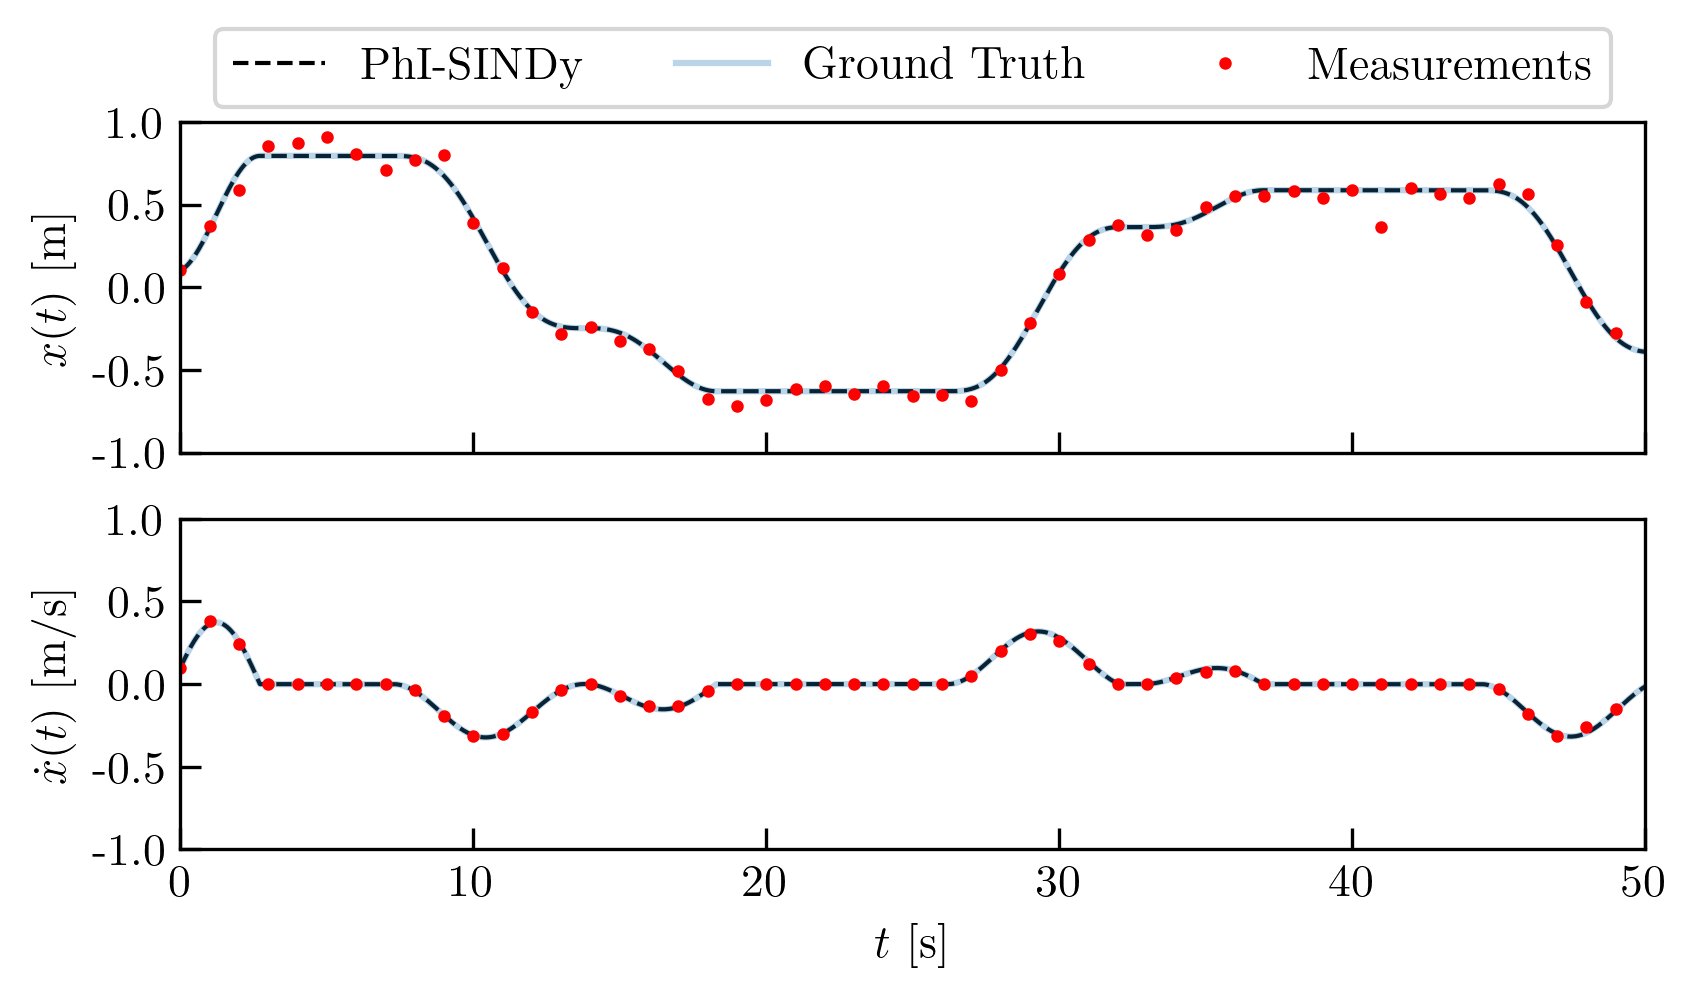

In [43]:
sol_learnt = solve_ivp(lambda t, x: learnt_model_scipy(x, t, learnt_coeffs, Params), [ts[0], ts[-1]], Params.x0, t_eval=ts,)
x_learnt = np.transpose(sol_learnt.y)

_, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16*cm,8*cm), sharex=True)

ax1.plot(ts, x_learnt[:, 0], "k--", linewidth=1, label='PhI-SINDy')
ax1.plot(ts, x_denoised[:, 0], linewidth=1.5, alpha=0.3, label='Ground Truth')
ax1.plot(ts[::100], x[::100, 0], "ro", markersize=2, label='Measurements')
ax2.plot(ts, x_learnt[:, 1], "k--", linewidth=1, label='PhI-SINDy')
ax2.plot(ts, x_denoised[:, 1], linewidth=1.5, alpha=0.3, label='Ground Truth')
ax2.plot(ts[::100], x[::100, 1], "ro", markersize=2, linewidth=4, label='Measurements')

plt.xlabel("$t$ [s]")
ax1.set_ylabel("$x(t)$ [m]")
ax2.set_ylabel("$\dot{x}(t)$ [m/s]")

ax1.set_yticks(np.arange(-1, 1.1, 0.5),np.arange(-1, 1.1, 0.5))
ax2.set_xticks(np.arange(0, 50.1, 10), np.arange(0, 50.1, 10))
ax2.set_yticks(np.arange(-1, 1.1, 0.5),np.arange(-1, 1.1, 0.5))

ax1.set_ylim((-1, 1))
ax2.set_ylim((-1, 1))
ax2.set_xlim((0, 50))

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 2.55), ncols=3, fontsize=11)
ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) 
ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) 
ax1.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax2.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

# plt.savefig("test.png",bbox_inches='tight')

plt.show()
